In [7]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy import sparse 
import sys
from gaussiandata import SyntheticTarget
from onlinePrototypes import protonline
from onlineCriticism import crionline
#import greedy_functions
import math
import scipy
import matplotlib.pyplot as plt 
%matplotlib inline

In [8]:
SEED = 666
number_of_gaussians = 3
ex = SyntheticTarget(seed=SEED, dist_components=number_of_gaussians)

N = 100
M = 5
data = ex.draw_sample(N)
print  data.size
print data[(2,3,4),:]
gamma = 2
kernel_matrix = rbf_kernel(data, gamma = gamma)

200
[[ 1.99020324 -2.16486934]
 [ 0.23045955 -2.20322567]
 [ 0.13977354 -1.94715913]]


In [9]:
def rbf(x,y, gamma):
    x = np.asarray(x)
    y = np.asarray(y)
    return scipy.exp(-gamma*np.linalg.norm(x-y))

def our_rbf_kernel(current_kernel_subset,  gamma, x_new, n, M, data, current_indices):
    print "we are in the update kernel"
    print "this is the current kernel subset to modify"
    print current_kernel_subset.shape
    
    new_row = np.zeros(n+1)
    new_col = np.zeros(M)
    
    print "new_row"
    print new_row
    print new_row.shape
    
    for i in range(n+1):
        new_row[i] = rbf(x = x_new, y = data[i], gamma = gamma)
         
    new_col = new_row[current_indices]
    
    new_row = np.matrix(new_row)
    print "this is the new_row"
    print new_row
    print new_row.shape
    new_col = np.matrix(new_col)
    print "this is the new_col"
    print new_col
    print new_col.shape
    
    new_kernel_subset = np.hstack((current_kernel_subset, new_col.T))
    #print new_kernel_subset.shape
    new_kernel_subset = np.vstack((new_kernel_subset, new_row))
    #print new_kernel_subset.shape
    return new_kernel_subset

In [10]:

def onlineGreedy(gamma, M, data, N):


    prototype_indices = np.arange(M) #assign first M points as prototypes. CONSIDER another method later.
    criticism_indices = np.arange(M, 2*M) # assign second M points as prototypes.

    current_kernel_matrix = rbf_kernel(data[range(2*M)], gamma = gamma)
    current_kernel_matrix_proto = current_kernel_matrix[:M]
    current_kernel_matrix_criticism = current_kernel_matrix[range(M, 2*M)]


    for i in range(2*M, N):
    
        new_point_index = i # assign the new data point index
        accept = 1 # decide whether to skip the criticism part or not 
    
        #prototype part
        #if accept == 1:
        #add new column and row to the kernel matrix for the new point; 
        #kernel matrix is always growing
        #current_kernel_subset,  gamma, x_new, n, timeseries):
        
        print "here"
        print "i"
        print i
    
        print "initial kernel proto"
        print current_kernel_matrix_proto.shape
        new_kernel_matrix_proto = our_rbf_kernel(current_kernel_subset = current_kernel_matrix_proto, gamma = gamma,  
                                                 x_new= data[i], n = i, M = M,  data = data[range(i+1)], 
                                                 current_indices = prototype_indices)
        print "this is the upodated kernel for proto"
        print new_kernel_matrix_proto.shape
    
        print "initial kernel critic"
        print current_kernel_matrix_criticism.shape
        new_kernel_matrix_criticism = our_rbf_kernel(current_kernel_subset = current_kernel_matrix_criticism, gamma = gamma,  
                                                 x_new= data[i], n = i, M = M,  data = data[range(i+1)], 
                                                 current_indices = criticism_indices)
        #new_kernel_matrix_criticism = np.delete(new_kernel_matrix_criticism, M,0)
        print "this is the upodated kernel for critic"
        print new_kernel_matrix_criticism.shape

        #run the greedy algorithm on these M+1 data points to select M prototypes
        #print prototype_indices
        prototype_indices_temp = protonline(new_kernel_matrix_proto, selectedprotos = prototype_indices, m = M)
        #print "prototype_indices_temp"
        #print type(prototype_indices_temp)
        #print "prototype_indices"
        #print type(prototype_indices)
        prototype_indices_temp = np.sort(prototype_indices_temp)
        prototype_indices = np.sort(prototype_indices)
        print prototype_indices_temp
        print prototype_indices
        print all(prototype_indices_temp == prototype_indices)
    
        if all(prototype_indices_temp == prototype_indices):
            #accept = 0 
        
            print "the point is not accepted"
            print current_kernel_matrix_criticism
            print current_kernel_matrix_criticism.shape
            print type(current_kernel_matrix_criticism)
       
            print "this is the upodated kernel for critic for the SECOND time"
            print new_kernel_matrix_criticism.shape
            #run the greedy algorithm on these M+1 data points to select M criticism
            print "******************critic**************************"
            criticism_indices_temp = crionline(new_kernel_matrix_criticism, 
                                                  selectedprotos = prototype_indices, 
                                                  selectedcritic = criticism_indices, c = M, reg='logdet')

            criticism_indices_temp = np.sort(criticism_indices_temp)
            criticism_indices = np.sort(criticism_indices)
            print criticism_indices_temp
            print criticism_indices
            print all(criticism_indices_temp == criticism_indices)
        
            if all(criticism_indices_temp == criticism_indices):  ##order and then check
                accept = 0
                current_kernel_matrix_proto = np.delete(new_kernel_matrix_proto, M, 0)
                current_kernel_matrix_criticism = np.delete(new_kernel_matrix_criticism, M, 0)
        
            else:
                ##delete the row
                print "difference"
                difference = np.setdiff1d(criticism_indices, criticism_indices_temp)
                print difference
                to_select = np.where(criticism_indices == difference)[0]
                print to_select
            
                criticism_indices = criticism_indices_temp # update the indices
                print new_kernel_matrix_criticism.shape
                current_kernel_matrix_criticism = np.delete(new_kernel_matrix_criticism, to_select,0) # update the kernel matrix
                current_kernel_matrix_proto = np.delete(new_kernel_matrix_proto, M, 0)
        
        else:
            print "ciao"
            print "the point is accepted"
            print "prototype_indices"
            print prototype_indices
            print "prototype_indices_temp"
            print prototype_indices_temp
            print "current_kernel_matrix_proto"
            #print current_kernel_matrix_proto
            print current_kernel_matrix_proto.shape
            print "new_kernel_matrix_proto"
            #print new_kernel_matrix_proto
            print new_kernel_matrix_proto.shape
            print "difference"
            difference = np.setdiff1d(prototype_indices, prototype_indices_temp)
            print difference
            to_select = np.where(prototype_indices == difference)[0]
            print to_select
           
            prototype_indices = prototype_indices_temp # update the indices
            print new_kernel_matrix_proto.shape
            current_kernel_matrix_proto = np.delete(new_kernel_matrix_proto, to_select,0) # update the kernel matrix
            print current_kernel_matrix_proto.shape
            current_kernel_matrix_criticism = np.delete(new_kernel_matrix_criticism, M, 0)
        
    return [prototype_indices, criticism_indices]


In [14]:
result = onlineGreedy(gamma, M, data, N)

here
i
10
initial kernel proto
(5, 10)
we are in the update kernel
this is the current kernel subset to modify
(5, 10)
new_row
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(11,)
this is the new_row
[[ 0.09903618  0.04022685  0.77881917  0.03488962  0.02911856  0.02148823
   0.39261531  0.52791438  0.18360278  0.22040783  1.        ]]
(1, 11)
this is the new_col
[[ 0.09903618  0.04022685  0.77881917  0.03488962  0.02911856]]
(1, 5)
this is the upodated kernel for proto
(6, 11)
initial kernel critic
(5, 10)
we are in the update kernel
this is the current kernel subset to modify
(5, 10)
new_row
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(11,)
this is the new_row
[[ 0.09903618  0.04022685  0.77881917  0.03488962  0.02911856  0.02148823
   0.39261531  0.52791438  0.18360278  0.22040783  1.        ]]
(1, 11)
this is the new_col
[[ 0.02148823  0.39261531  0.52791438  0.18360278  0.22040783]]
(1, 5)
this is the upodated kernel for critic
(6, 11)
[ 0  1  2  3 10]
[0 1 2 3 4]
False
ciao
the 

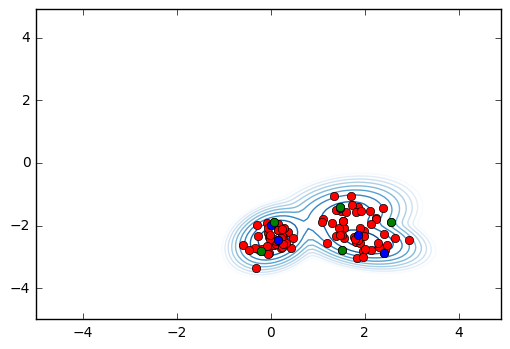

In [15]:
ex.plot()
plt.plot(data[:N,0], data[:N,1], 'ro');
plt.plot(data[result[0],0], data[result[0],1], 'bo');
plt.plot(data[result[1],0], data[result[1],1], 'go');